## Convergence rates for the Frank-Wolfe algorithm

This project aims at solving the constrained optimization problem:
\begin{equation}
    \min_{x \in C}f(x)
\end{equation}
where $C \subseteq \mathbb{R}^d$  is a nonempty compact convex set, and $f: \mathbb{R}^d \rightarrow \mathbb{R}$ is a  $C^1$ function, using the Frank-Wolfe algorithm.

In [2]:
# Preamble: useful toolboxes, librairies, functions, etc.

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
from functools import partial


We implement the linear minimization oracles that return a solution to the following problem :
\begin{equation}
\min_{p \in C} \langle a,p \rangle, \tag{2}
\end{equation}
where $C $ is $C_2$, $C_{\infty}$, or $C_\mathcal{P}$.   


In [3]:
## Linear minimization oracles 

def lmo2(a):
    return - a / np.linalg.norm(a)

def lmoInf(a):
    return - np.sign(a)

def lmoProb(a):
    i = np.argmin(a)
    pP = np.zeros_like(a)
    pP[i] = 1
    return pP


We implement the Frank-Wolfe algorithm with open-loop step-size, constant open-loop step-size and exact linesearch.

In [4]:
def franck_wolf(
        f, 
        grad, 
        x0, 
        T, 
        constrained_set, 
        l=4, 
        const_step_size=None,
        A=None,
        b=None,
        update="open_loop"):
    """
    Implementation of Franck Wolf algorithm

    Args:
        f (function): objective function
        grad (function): gradient of the objective function
        x0 (numpy array): initial point
        T (int): number of iteration
        constrained_set (str) : constrained set
        l (int): open-loop step-size parameter
        const_step_size (float) : constant open-loop step-size parameter
        A (numpy array) : for linesearch
        b (numpy array) : for linesearch
        update (str) : update rule

    Returns:
        iterates (numpy array) : iterates of FW algortihm
        vals (numpy array) : values of the objective function for the iterates
    """
    
        
    d = np.shape(x0)[0]
    

    if constrained_set == "2":
        lmo = lmo2
    elif constrained_set == "Inf":
        lmo = lmoInf
    elif constrained_set == "Prob":
        lmo = lmoProb
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((T+1,d)) # iterates, starting at x_{-1}
    vals = np.zeros(T+1)
    iterates[0,:] = x0 
    vals[0] = f(x0)

    x = x0
    for t in range(T):
        p = lmo(grad(x)) # LMO
    
        if update == "const_open_loop":
            # Constant open loop step-size
            eta = const_step_size 
        elif update == "open_loop":
            # Open-loop step-size
            eta = l / (t + l)
        elif update == "linesearch":
            eta = quadratic_linesearch(x, p, A, b)
        x = (1 - eta) * x + eta * p
        # Logs
        iterates[t+1,:] = x
        vals[t+1] = f(x)

    print('Final value: ', vals[T])
    # print('Final iterate:', iterates[T])
    
    return (iterates, vals)

In [5]:
def quadratic_linesearch(x, p, A, b):
    """
    Closed-form expression for the linesarch if the objective is quadratic
    """

    A_p_x = A @ (p - x) # Intermediar computation 

    a_ = 0.5 * np.linalg.norm(A_p_x)**2
    b_ = np.dot(A_p_x, A @ x - b)

    dP = 2 * a_ + b_

    if dP > 0:
        return -b_ / (2 * a_)
    else:
        return 1

In [6]:
def generate_x0(d, constrained_set):
    """
    Initialization for FW algorithm in the constrained set
    """
    rng = np.random.default_rng(123456)  # sets the seed
    myrandomvec = rng.random(d)  # random vector in the half-open interval [0.0, 1.0)

    if constrained_set == "2":  # ℓ2 unit ball
        x0 = myrandomvec / np.linalg.norm(myrandomvec)  # Normalize to unit ℓ2 norm

    elif constrained_set == "Inf":  # ℓ∞ unit ball
        x0 = myrandomvec / np.max(np.abs(myrandomvec))  # Scale to max abs value of 1

    elif constrained_set == "Prob":  # Probability simplex
        x0 = myrandomvec / np.sum(myrandomvec)  # Normalize so that components sum up to 1

    else:
        raise ValueError("Invalid set specified")

    return x0

In [7]:
def plot_optimization_path(optimization_path, function, constrained_set):

    if constrained_set == "Inf":
        lims = [-1.5, 1.5]
        plt.fill([-1, -1, 1, 1, -1], [-1, 1, 1, -1, -1], color="b", alpha=0.2, label="$l_\infty$ unit ball")
    elif constrained_set == "Prob":
        lims = [-0.5, 1.5]
        plt.plot([0, 1], [1, 0], color="b",alpha=0.2, label ="Probability simplex")
    elif constrained_set == "2":
        lims = [-1.5, 1.5]
        circle = plt.Circle((0, 0), 1, color='b', alpha=0.2, label="$L_2$ unit ball")
        plt.gca().add_artist(circle)  
        
    # Create a grid of points
    x = np.linspace(lims[0], lims[1], 400)
    y = np.linspace(lims[0], lims[1], 400)
    X, Y = np.meshgrid(x, y)

    # Evaluate the function on the grid
    Z = function(np.array([X, Y]))

    # Plot level sets
    plt.contour(X, Y, Z, levels=15, cmap='viridis')



    # Plot optimization path
    plt.plot(optimization_path[:,0], optimization_path[:,1], 'r-o', label = "Optimization path") # 'r-o' for red line with circle markers

    # Draw x and y axis lines
    plt.axhline(0, color='black',linewidth=0.8)
    plt.axvline(0, color='black',linewidth=0.8)

    # Set plot limits and labels
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

## Question 6 & 13

We investigate the performance of FW algorithm with open-loop step-size and exact line-search in the following setting (Theorem 3.6):
- Objective $f$ : (HEB)
- Location of $x^*$ : relative interior of
the feasible region $C$.

We consider the function $f(x) = \frac{1}{2} \| x \|_2^2$ on the probability simplex $C_\mathcal{P}$ with unique minimizer $x^* = \frac{1}{d}(1,\dots, 1)$.

In [9]:
# Objective function
def f1(x):
    return np.sum(x**2, axis=0) / 2

# Gradient of the objevtive function
def grad_f1(x):
    return x 

Energy decay in a medium-size problem

Final value:  0.005000000066659786
Final value:  0.005000000000004751


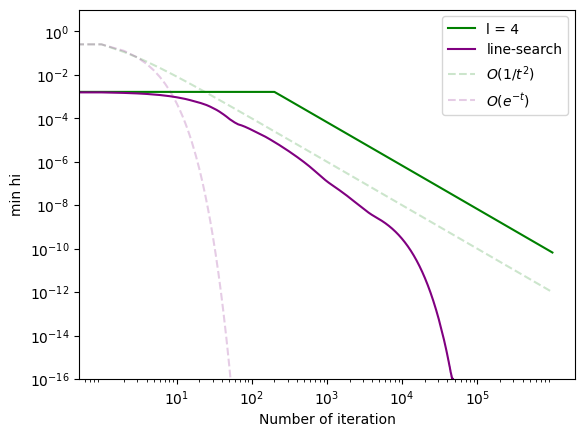

In [10]:
constrained_set = "Prob"
d = 100
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter
T = int(10e5)

# Compute the HEB parameters
mu = np.sqrt(2 / m)
theta = 1 / 2

x_opt = np.ones(d) / d
val_opt = f1(x_opt)

x0 = generate_x0(d, constrained_set)

## Open loop step size l=4
iterates, vals = franck_wolf(
    f1,
    grad_f1,
    x0, 
    T,
    constrained_set, 
    l=4,
    update="open_loop")

plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"l = {4}", color="g")

## Exact line serach
iterates, vals = franck_wolf(
        f1,
        grad_f1,
        x0, T,
        constrained_set, 
        A=np.eye(d),
        b= np.zeros(d),
        update="linesearch")

plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"line-search", color="purple")


## Order of convergence rates
plt.loglog([1/t**(2) for t in range(1, T + 1)], label = f"$O(1/t^2)$", linestyle='--', color="g", alpha=0.2)
plt.loglog([0.5**t for t in range(1, T + 1)], label = f"$O(e^{{-t}})$", linestyle='--', color="purple", alpha=0.2)

plt.ylabel("min hi")
plt.xlabel("Number of iteration")
plt.ylim(bottom=10**-16, top =10)
plt.xticks([10**i for i in range(1, 6)])
plt.legend()

Optimization path, FW open-loop $\eta_t = \frac{4}{t+4}$

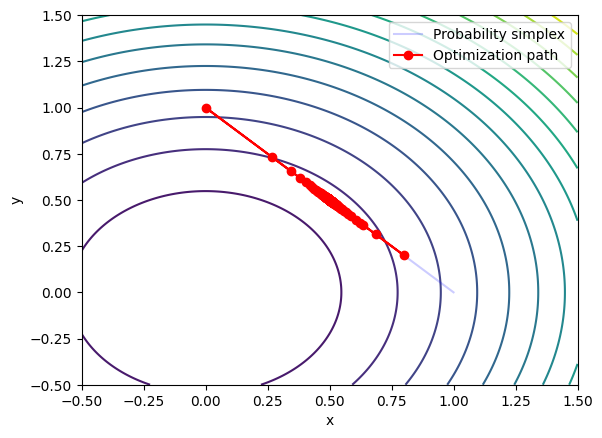

In [277]:
constrained_set = "Prob"
d = 2
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter
T = int(10e5)

# Compute the HEB parameters
mu = np.sqrt(2 / m)
theta = 1 / 2

x_opt = np.ones(d) / d

x0 = generate_x0(d, constrained_set)
val_opt = f1(x_opt)

## Open loop step size
iterates, vals = franck_wolf(
    f1,
    grad_f1,
    x0, 
    T,
    constrained_set, 
    l=4,
    update="open_loop")

plot_optimization_path(iterates, f1)

Optimization path, FW line-search

Final value:  0.25


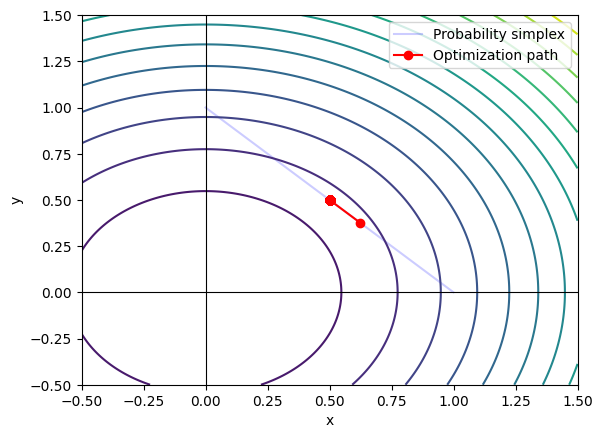

In [11]:
constrained_set = "Prob"
d = 2
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter
T = int(10e5)

# Compute the HEB parameters
mu = np.sqrt(2 / m)
theta = 1 / 2

x_opt = np.ones(d) / d
val_opt = f1(x_opt)

x0 = generate_x0(d, constrained_set)

## Exact line serach
iterates, vals = franck_wolf(
        f1,
        grad_f1,
        x0, T,
        constrained_set, 
        A=np.eye(d),
        b= np.zeros(d),
        update="linesearch")

plot_optimization_path(iterates, f1, constrained_set)

## Question 8 & 13

We investigate the performance of FW algorithm with open-loop step-size and exact line-search in the following setting (Theorem 4.5):
- Region $C$ : polytope
- Objective $f$ : strongly convex
- Location of $x^*$ : relative interior of a face of C 

We consider the function $$f(x) = \frac{1}{2} \left\lVert x - \rho  \bar{\mathbf{1}} \right\rVert^2 $$  such that $\bar{\mathbf{1}} = (0, \ldots, 0, 1, \ldots, 1)
$ with $\frac{d}{2}$ zeros and $\frac{d}{2}$
ones (we assume d is even), where $\rho \geq \frac{2}{d}$, on the probability simplex $C_\mathcal{P}$ with unique minimizer $ x^* = \frac{2}{d} \bar{\mathbf{1}}$.

In [12]:
def create_vector(d):
    # Create a vector with d/2 zeros and d/2 ones
    return np.array([0] * (d // 2) + [1] * (d // 2))

def f2(x, rho):
    d = x.shape[0]
    bar_1 = create_vector(d)
    # # Calculate the function value

    # Reshape bar_1 based on the dimension of x
    if x.ndim == 1:  # x is a 1D array
        bar_1_reshaped = bar_1
    elif x.ndim == 3:  # x is a 3D array (from np.array([X, Y]))
        bar_1_reshaped = bar_1[:, np.newaxis, np.newaxis]
    else:
        raise ValueError("Unexpected shape of x. x should be either 1D or 3D.")

    # Compute the difference
    diff = x - rho * bar_1_reshaped

    # Calculate the squared norm
    return 0.5 * np.sum(diff**2, axis=0)

def grad_f2(x, rho):
    d = x.shape[0]
    bar_1 = create_vector(d)
    return x - rho * bar_1
    

Energy-decay $\rho = 0.25$

rho >= 2 / d
Final value:  1.322500000000002
Final value:  1.3225000008329828
Final value:  1.3225000033319005
Final value:  1.3225048948873022


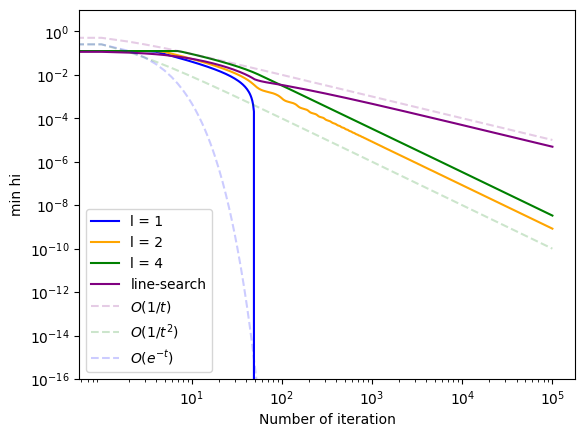

In [14]:
constrained_set = "Prob"
rho = 0.25
d = 100 # dimension
T = int(10e4)
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter

## Defining objective function
f2_ = partial(f2, rho = rho)
grad_f2_ = partial(grad_f2, rho = rho)

if 0 < rho < 2 / d:
    print("0 < rho < 2 / d")
    x_opt = create_vector(d) * rho / 2 - create_vector(d)[::-1] * rho / 2 + 1 / d
elif rho > 2 / d:
    print("rho >= 2 / d")
    x_opt = create_vector(d) * 2 / d
val_opt = f2_(x_opt)

x0 = generate_x0(d, constrained_set)

colors = ["b", "orange", "g", "purple"]
for i, l in enumerate([1, 2, 4]):
    iterates, vals = franck_wolf(
        f2_,
        grad_f2_,
        x0,
        T, 
        constrained_set, 
        l=l,
        update="open_loop")

    plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"l = {l}", color=colors[i])


# Exact line-search (Question 13 - setting 2)
iterates, vals = franck_wolf(
        f2_,
        grad_f2_,
        x0, T,
        constrained_set, 
        A=np.eye(d),
        b=rho * create_vector(d),
        update="linesearch")

plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"line-search", color="purple")

# Order of convergences
plt.loglog([1/t for t in range(1, T + 1)], label = f"$O(1/t)$", linestyle='--', color="purple", alpha=0.2) # line-search
plt.loglog([1/t**(2) for t in range(1, T + 1)], label = f"$O(1/t^2)$", linestyle='--', color=colors[2], alpha=0.2) # l in {2, 4}
plt.loglog([(0.5 ** t) for t in range(1, T + 1)], label = f"$O(e^{{-t}})$", linestyle='--', color=colors[0], alpha=0.2) # l=1

plt.ylabel("min hi")
plt.xlabel("Number of iteration")
plt.ylim(bottom=10**-16, top =10)
plt.xticks([10**i for i in range(1, 6)])
plt.legend()



Optimization path $\rho =0.25$,  FW open-loop $\eta_t = \frac{4}{t+4}$

rho >= 2 / d
Final value:  0.5


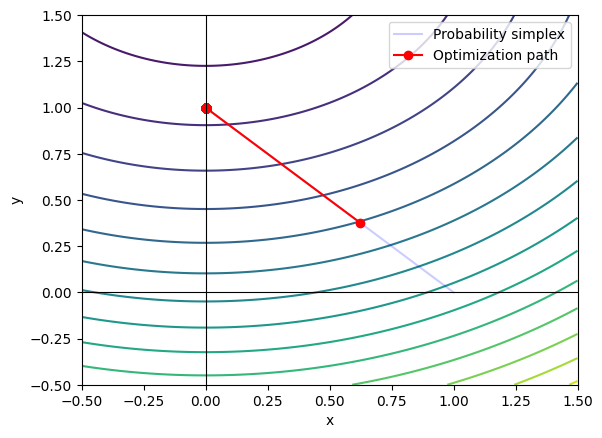

In [311]:
constrained_set = "Prob"
rho = 2
d = 0.25 # dimension
T = int(10e4)
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter

## Defining objective function
f2_ = partial(f2, rho = rho)
grad_f2_ = partial(grad_f2, rho = rho)

if 0 < rho < 2 / d:
    print("0 < rho < 2 / d")
    x_opt = create_vector(d) * rho / 2 - create_vector(d)[::-1] * rho / 2 + 1 / d
elif rho > 2 / d:
    print("rho >= 2 / d")
    x_opt = create_vector(d) * 2 / d
val_opt = f2_(x_opt)

x0 = generate_x0(d, constrained_set)

iterates, vals = franck_wolf(
        f2_,
        grad_f2_,
        x0,
        T, 
        constrained_set, 
        l=4,
        update="open_loop")

plot_optimization_path(iterates, f2_, constrained_set)


Optimization path $\rho = 2$

rho >= 2 / d
Final value:  98.01000000000002
Final value:  98.01000000083299
Final value:  98.0100000033319
Final value:  98.00999999999999


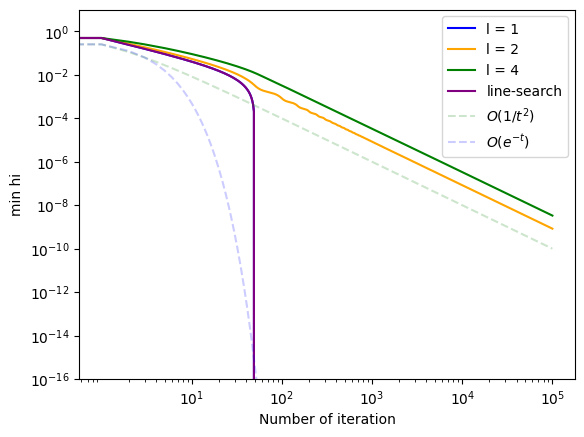

In [15]:
constrained_set = "Prob"
rho = 2
d = 100 # dimension
T = int(10e4)
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter

## Defining objective function
f2_ = partial(f2, rho = rho)
grad_f2_ = partial(grad_f2, rho = rho)

if 0 < rho < 2 / d:
    print("0 < rho < 2 / d")
    x_opt = create_vector(d) * rho / 2 - create_vector(d)[::-1] * rho / 2 + 1 / d
elif rho > 2 / d:
    print("rho >= 2 / d")
    x_opt = create_vector(d) * 2 / d
val_opt = f2_(x_opt)

x0 = generate_x0(d, constrained_set)

colors = ["b", "orange", "g", "purple"]
for i, l in enumerate([1, 2, 4]):
    iterates, vals = franck_wolf(
        f2_,
        grad_f2_,
        x0,
        T, 
        constrained_set, 
        l=l,
        update="open_loop")

    plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"l = {l}", color=colors[i])


# Exact line-search (Question 13 - setting 2)
iterates, vals = franck_wolf(
        f2_,
        grad_f2_,
        x0, T,
        constrained_set, 
        A=np.eye(d),
        b=rho * create_vector(d),
        update="linesearch")

plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"line-search", color="purple")

# Order of convergences
plt.loglog([1/t**(2) for t in range(1, T + 1)], label = f"$O(1/t^2)$", linestyle='--', color=colors[2], alpha=0.2) # l in {2, 4}
plt.loglog([(0.5 ** t) for t in range(1, T + 1)], label = f"$O(e^{{-t}})$", linestyle='--', color=colors[0], alpha=0.2) # l=1 or linesearch

plt.ylabel("min hi")
plt.xlabel("Number of iteration")
plt.ylim(bottom=10**-16, top =10)
plt.xticks([10**i for i in range(1, 6)])
plt.legend()



Optimization path $\rho = 2$, FW line-search

rho >= 2 / d
Final value:  0.5


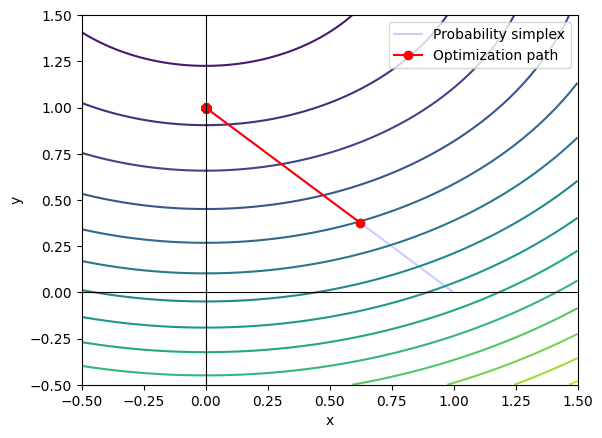

In [18]:
constrained_set = "Prob"
rho = 2
d = 2 # dimension
T = int(10e4)
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter

## Defining objective function
f2_ = partial(f2, rho = rho)
grad_f2_ = partial(grad_f2, rho = rho)

if 0 < rho < 2 / d:
    print("0 < rho < 2 / d")
    x_opt = create_vector(d) * rho / 2 - create_vector(d)[::-1] * rho / 2 + 1 / d
elif rho > 2 / d:
    print("rho >= 2 / d")
    x_opt = create_vector(d) * 2 / d
val_opt = f2_(x_opt)

x0 = generate_x0(d, constrained_set)

iterates, vals = franck_wolf(
        f2_,
        grad_f2_,
        x0,
        T, 
        constrained_set, 
        A=np.eye(d),
        b=rho * create_vector(d),
        update="linesearch")

plot_optimization_path(iterates, f2_, constrained_set)


## Question 9 & 13

We try to observe similar behaviors with $C=C_\infty$ as with the probability simplex in the setting of Question 6 (Theorem 3.6), that is:
- Region $C$ : polytope
- Objective $f$ : strongly convex
- Location of $x^*$ : relative interior of a face of C 

We consider the function $f(x) = \frac{1}{2} \| x \|_2^2$ on the $l_\infty$ unit norm $C_\infty$ with unique minimizer $x^* = 0$.

Final value:  1.9999940000165555e-10
Final value:  0.0


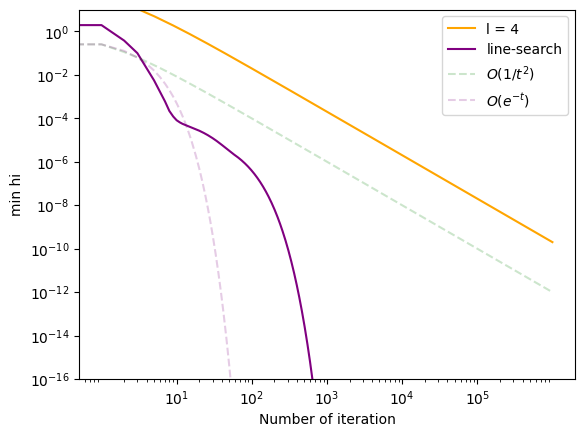

In [22]:
constrained_set = "Inf"
d = 100
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
T = int(10e5)

x_opt = 0.
val_opt = f1(x_opt)

x0 = generate_x0(d, constrained_set)
## Open loop step size
iterates, vals = franck_wolf(
    f1,
    grad_f1,
    x0, 
    T,
    constrained_set, 
    l=4,
    update="open_loop")

plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"l = {4}", color="orange")

## Exact line serach
iterates, vals = franck_wolf(
        f1,
        grad_f1,
        x0, T,
        constrained_set, 
        A=np.eye(d),
        b= np.zeros(d),
        update="linesearch")

plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"line-search", color="purple")


## Order of convergence rates
plt.loglog([1/t**(2) for t in range(1, T + 1)], label = f"$O(1/t^2)$", linestyle='--', color="g", alpha=0.2)
plt.loglog([0.5**t for t in range(1, T + 1)], label = f"$O(e^{{-t}})$", linestyle='--', color="purple", alpha=0.2)

plt.ylabel("min hi")
plt.xlabel("Number of iteration")
plt.ylim(bottom=10**-16, top =10)
plt.xticks([10**i for i in range(1, 6)])
plt.legend()


Optimization path  FW open-loop $\eta_t = \frac{4}{t+4}$

Final value:  3.999988000033112e-12


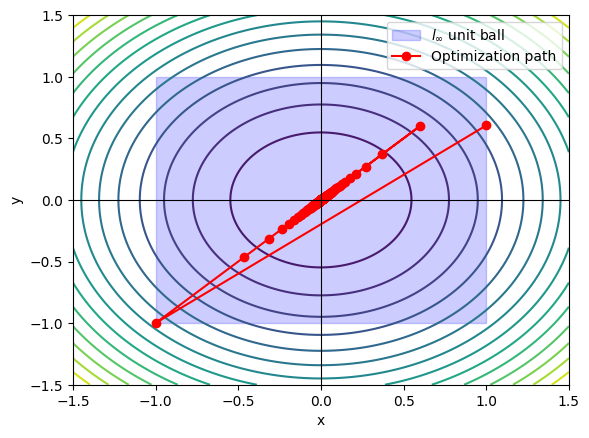

In [25]:
constrained_set = "Inf"
d = 2
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter
T = int(10e5)

# Compute the HEB parameters
mu = np.sqrt(2 / m)
theta = 1 / 2

x_opt = np.ones(d) / d

x0 = generate_x0(d, constrained_set)
val_opt = f1(x_opt)

## Open loop step size
iterates, vals = franck_wolf(
    f1,
    grad_f1,
    x0, 
    T,
    constrained_set, 
    l=4,
    update="open_loop")

plot_optimization_path(iterates, f1, constrained_set="Inf")

Final value:  0.0


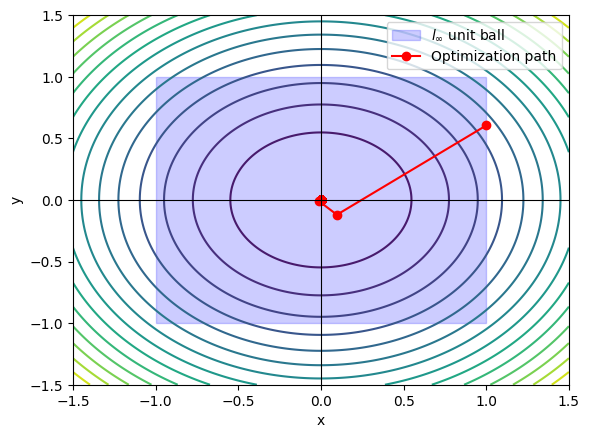

In [26]:
constrained_set = "Inf"
d = 2
L = 1 # L-smoothsness constant
m = 1 # strongly convex constant
delta = np.sqrt(2) # cunstrained set diameter
beta = 1 / d # relative interior parameter
T = int(10e5)

# Compute the HEB parameters
mu = np.sqrt(2 / m)
theta = 1 / 2

x_opt = np.ones(d) / d

x0 = generate_x0(d, constrained_set)
val_opt = f1(x_opt)

## Exact line serach
iterates, vals = franck_wolf(
        f1,
        grad_f1,
        x0, T,
        constrained_set, 
        A=np.eye(d),
        b= np.zeros(d),
        update="linesearch")

plot_optimization_path(iterates, f1, constrained_set="Inf")

## Question 12 & 13

We investigate the performance of FW algorithm with open-loop step-size and exact line-search in the following setting (Theorem 3.10):
- Region $C$ : strongly convex
- Objective $f$ : lower-bounded gradients

We consider the function $f(x) = \frac{1}{2} \|A x - b \|_2^2$ on the $l_2$ unit ball $C_2$ where $b = A x^\dagger$ with $x^\dagger \in \text{Im}(A^T)$, $\|x^\dagger\|_2^2 = 2$ and $A \in \mathbb{R}^{N \times d}$ s.t. $N < d$

In [33]:
def generate_f3(N, d, max_eig, min_eig = 10e-2):

    rng = np.random.default_rng(123456)  # Sets the seed
    assert N < d, "Ensure that N < d"

    # Create a diagonal matrix with eigenvalues spread between min_eig and max_eig
    eigenvalues =  list(np.linspace(min_eig, max_eig, N))
    D = np.diag(eigenvalues)

    # Generate a random orthogonal matrix Q
    Q, _ = np.linalg.qr(rng.random((d, d)))

    # Construct A such that A^T A has the desired eigenvalues
    # Only first N columns of Q are used
    A =  np.sqrt(D) @ Q[:, :N].T
    # A = rng.random((N, d))
    # print("eigen ", np.linalg.eigvals(A.T @ A))

    random_vector = rng.random(N)
    x_dagger = (np.sqrt(2) / np.linalg.norm(A.T @ random_vector)) * (A.T @ random_vector)
    assert np.isclose(np.linalg.norm(x_dagger)**2, 2)
    
    b = A @ x_dagger

    def f3(x):
        # Check if x is 1D or 3D
        if x.ndim == 1:  # x is a 1D array
            b_reshaped = b
            # Compute the difference for 1D
            diff = A @ x - b_reshaped
            # Calculate the squared norm for 1D
            return 0.5 * np.sum(diff**2)

        elif x.ndim == 3:  # x is a 3D array (from np.array([X, Y]))
            # Reshape x for matrix multiplication
            x_flattened = x.reshape(2, -1)
            # Perform matrix multiplication and reshape b appropriately
            diff = A @ x_flattened - b[:, np.newaxis]
            # Reshape the result back to original grid shape and calculate the squared norm
            return 0.5 * np.sum(diff**2, axis=0).reshape(x.shape[1:])

        else:
            raise ValueError("Unexpected shape of x. x should be either 1D or 3D.")

    def grad_f3(x):
        return A.T @ (A @ x - b)

    return f3, grad_f3, A, b

def dichotomic_algorithm(f, low, high, precision=1e-16, return_path = False):

    assert f(low) * f(high) <= 0, "f(low) and f(high) should have opposite sign"

    iterates = []
    vals = []

    while (high - low) > precision:
        mu = (high + low) / 2
        val = f(mu)
        iterates.append(mu)
        vals.append(val)

        if val * f(low) <= 0:
            high = mu
        else:
            low = mu
    print(f"Final value : {mu}")
    if return_path:
        return mu, iterates, vals
    else:
        return mu


def f_dichotomic(mu, A, b):
    """
    Compute the  ||(A^T A + mu I)^-1 A^T b||_2 - 1.
    """
    I = np.eye(A.shape[1])
    inv_term = np.linalg.inv(A.T @ A + mu * I)
    return np.linalg.norm(inv_term @ A.T @ b, 2) - 1

In [16]:
constrained_set = "2"
N = 50
d = 100
L = 1
T = int(10e5)

x0 = generate_x0(d, constrained_set)
f3, grad_f3, A, b = generate_f3(N, d, max_eig=L)

Using KKT conditions, one can show that the unique minimizer $x^*$ of $f$ on $C_2$ satisfy:
$$ g(\mu) = \|(A^T A + \mu )^{-1} A^T b \|_2 - 1 = 0$$ 
We then search $\mu^*$  using a dichotomic algorithm on g.


Final value : 0.2667441517544465
0.2667441517544465


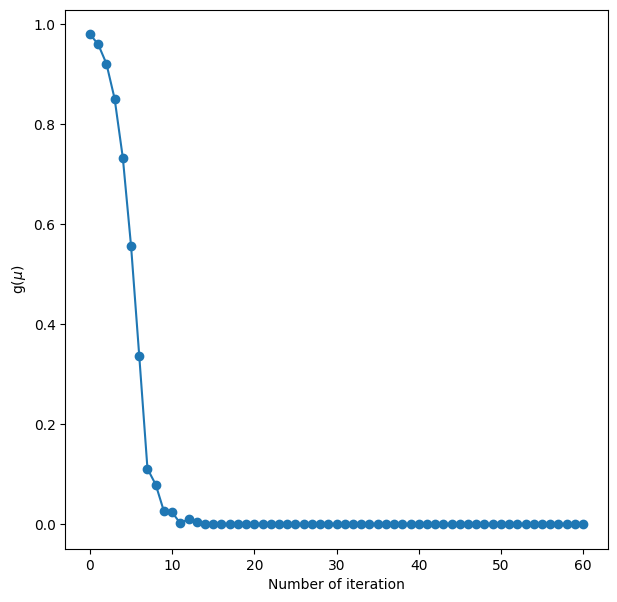

In [29]:
f_dichotomic_ = partial(f_dichotomic, A = A, b = b)
mu_opt, iterates_dicho, vals_dicho = dichotomic_algorithm(f_dichotomic_, low=10e-6, high=100, return_path=True)
print(mu_opt)

plt.plot(np.abs(np.array(vals_dicho) - 0.), '-o')
plt.xlabel("Number of iteration")
plt.ylabel("g($\mu$)")
plt.show()

Energy decay

Final value:  0.05285569520115687
Final value:  0.05285559158802834
Final value:  0.05285559158737206
Final value:  0.05285559158737022
Final value:  0.05285559158733974


c:\Users\matte\iCloudDrive\Documents\Studies\IASD\Optimization\Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


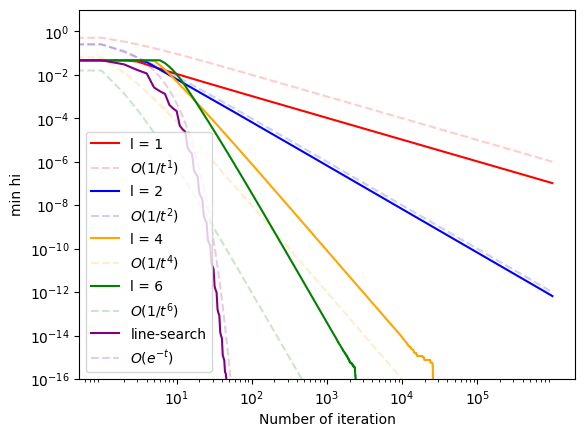

In [30]:
x_opt = np.linalg.inv(A.T @ A + mu_opt * np.eye(A.shape[1]))  @ A.T @ b
assert np.isclose(np.linalg.norm(x_opt), 1), "||x_opt|| should be equal to 1"
val_opt = f3(x_opt)

colors = ["r", "b", "orange", "g", "purple"]
## open-loop step-size
for i, l in enumerate([1, 2, 4, 6]):
    iterates, vals = franck_wolf(
        f3,
        grad_f3,
        x0, T,
        constrained_set, 
        l=l,
        update="open_loop")
    plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"l = {l}", color=colors[i])
    plt.loglog([1/t**(l) for t in range(1, T + 1)], label =  f"$O(1/t^{l})$", linestyle='--', color=colors[i], alpha=0.2)

# Exact line-search (Question 13 - setting 2)
iterates, vals = franck_wolf(
        f3,
        grad_f3,
        x0, T,
        constrained_set, 
        A=A,
        b=b,
        update="linesearch")

plt.loglog(np.minimum.accumulate(vals - val_opt), label = f"line-search", color="purple")
plt.loglog([0.5**t for t in range(1, T + 1)], label = f"$O(e^{{-t}})$", linestyle='--', color="purple", alpha=0.2)

plt.ylabel("min hi")
plt.xlabel("Number of iteration")
plt.ylim(bottom=10**-16, top =10)
plt.xticks([10**i for i in range(1, 6)])
plt.legend()
plt.show()

Optimization path

In [35]:
constrained_set = "2"
N = 1
d = 2
L = 1
T = int(10e5)

x0 = generate_x0(d, constrained_set)
f3, grad_f3, A, b = generate_f3(N, d, max_eig=L)

Final value : 0.041421356237309415
0.041421356237309415


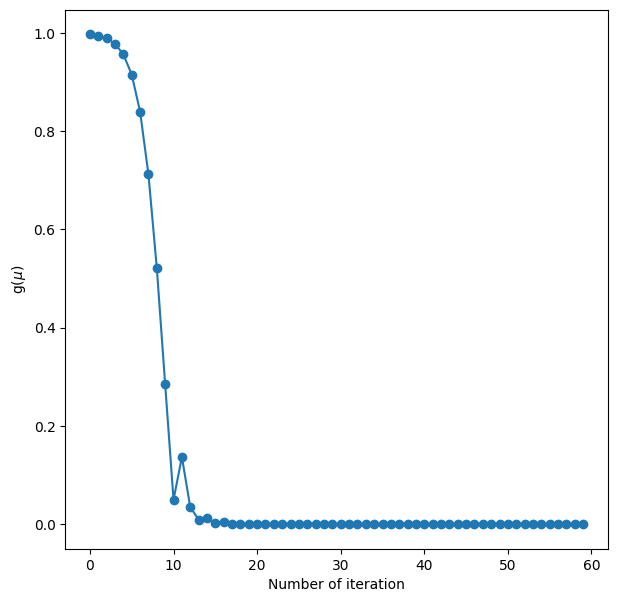

In [36]:
f_dichotomic_ = partial(f_dichotomic, A = A, b = b)
mu_opt, iterates_dicho, vals_dicho = dichotomic_algorithm(f_dichotomic_, low=10e-6, high=100, return_path=True)
print(mu_opt)


plt.figure(figsize=(7, 7))
plt.plot(np.abs(np.array(vals_dicho) - 0.), '-o')
plt.xlabel("Number of iteration")
plt.ylabel("g($\mu$)")
plt.show()

x_opt = np.linalg.inv(A.T @ A + mu_opt * np.eye(A.shape[1]))  @ A.T @ b
assert np.isclose(np.linalg.norm(x_opt), 1), "||x_opt|| should be equal to 1"
val_opt = f3(x_opt)

Optimization path, FW open-loop $\eta_t = \frac{4}{t+4}$

Final value:  0.008578643762690354


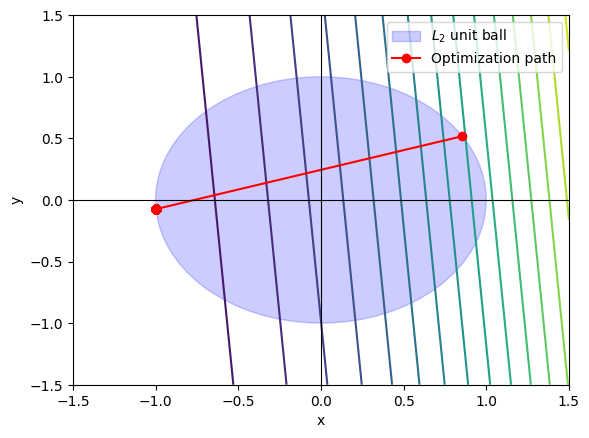

In [38]:
## Open-loop step-size
iterates, vals = franck_wolf(
        f3,
        grad_f3,
        x0, T,
        constrained_set, 
        l=4,
        update="open_loop")
    
plot_optimization_path(iterates, f3, constrained_set)

Optimization path, FW line-search

Final value:  0.0085786437626905


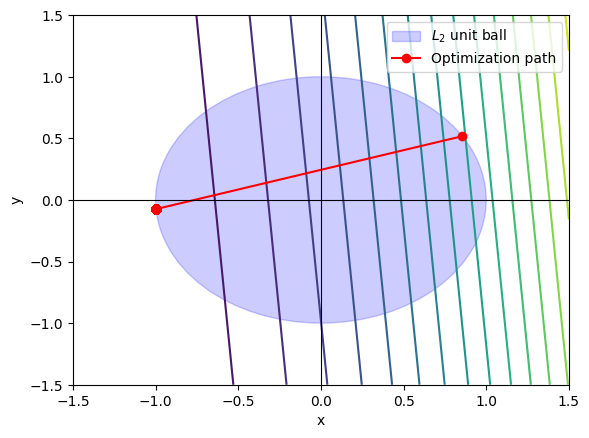

In [39]:
## Exact line-search
iterates, vals = franck_wolf(
        f3,
        grad_f3,
        x0, T,
        constrained_set, 
        A=A,
        b=b,
        update="linesearch")
    
plot_optimization_path(iterates, f3, constrained_set)